In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
import sys
#sys.path.append('/content/drive/My Drive/mdl_exercise5')

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import shutil,gzip
from IPython.utils import io
import torchvision.models as models

#run pip install for pytorch flop counter before first use
!pip install --upgrade git+https://github.com/Lyken17/pytorch-OpCounter.git
from thop import profile
!pip install -q wget
import wget

#some functions to count unique parameters and sparsity are provided
def countParameters(net):
    model_parameters = filter(lambda p: p.requires_grad, net.parameters())
    params = sum([p.numel() for p in model_parameters])
    return params

def countUnique(net):
    unique = 0
    for m in net.modules():
        if(isinstance(m,nn.Conv2d)):
            unique += len(np.unique(m.weight.data.cpu().flatten().numpy()))
    return unique
    #print('#unique',unique)

def countSparsity(net):
    count_nonzero = 0; count_zero = 0
    for m in net.modules():
        if(isinstance(m, nn.Conv2d)):
            count_nonzero += torch.sum((m.weight.data!=0).float())
            count_zero += torch.sum((m.weight.data==0).float())
    return count_zero/(count_zero+count_nonzero)
            

  Cloning https://github.com/Lyken17/pytorch-OpCounter.git to /tmp/pip-req-build-jwremf5l
  Running command git clone -q https://github.com/Lyken17/pytorch-OpCounter.git /tmp/pip-req-build-jwremf5l
  Created wheel for thop: filename=thop-0.0.4.post2106210645-cp37-none-any.whl size=8739 sha256=bc33d8419b6a3c98c8a65d9057b19025c4ee33a28a1897171ab88e79980a6db0
  Stored in directory: /tmp/pip-ephem-wheel-cache-gd4eb77v/wheels/79/0e/29/2d013ff0d3e36ae48894c11a6a9eecad6bc4789849f5ed802a
Successfully built thop


dict_keys(['__header__', '__version__', '__globals__', 'img_test', 'img_train', 'label_test', 'label_train'])


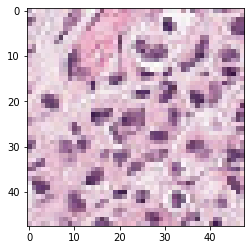

In [ ]:
#loading the patch-based wholeslide histopathology data (uint8) and converting it to torch tensors
import os

dataset_url = 'https://cloud.imi.uni-luebeck.de/s/sjjiReHqSnokJ2n/download'

def get_data(data_url):
    filename = './patchCamelyon8c.mat'
    if not os.path.exists(filename):
        filename = wget.download(data_url)
    
get_data(dataset_url)


data = scipy.io.loadmat('patchCamelyon8c.mat')
print(data.keys())

img_train = torch.from_numpy(data['img_train'].astype('float32')/255)
img_test = torch.from_numpy(data['img_test'].astype('float32')/255)

label_train = torch.from_numpy(data['label_train']).long()
label_test = torch.from_numpy(data['label_test']).long()

plt.imshow(img_test[100,:,:,:].permute(1,2,0))
plt.show()

In [ ]:
net = torchvision.models.vgg11_bn(pretrained='True')

input = torch.randn(128, 3, 48, 48)
with io.capture_output() as captured:
    #flops, params = profile(net.features, input_size=(128,3,48,48))
    flops, params = profile(net.features, inputs=(input, ))
print('#GFlops',flops/1e9)

print('#features',countParameters(net))

# ========== Task 1: ==========
# Replace the layer net.avgpool with an adaptive average pool of output size 1x1
# Create a new classifier as nn.Sequential with two linear layers (512x256 and 256x2)
# including one ReLU and no batch-norm. This reduces the parameter count to 9.4 million.
# Fine-tune this network for 16 sub-epochs with batch size = 128, learning rate = 0.0005,
# and decay = 0.9 (use only a random quarter of training patches per epoch).
# Evaluate the test accuracy (which should be ~94%, random_seed=7).


net.avgpool = nn.AdaptiveAvgPool2d((1,1))
net.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )


print('#features',countParameters(net))

net.cuda()

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth



#GFlops 44.127092736
#features 132868840
#features 9357826


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
#FINETUNE

torch.manual_seed(7)

nr_epx = 16
b_sz_train = 128
init_lr = 0.0005
decay = 0.9

# initialize the optimizer and scheduler
optimizer = optim.Adam(net.parameters(), lr=init_lr)#
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay)
metric = nn.CrossEntropyLoss()

run_loss = np.zeros(nr_epx)/0
run_acc = np.zeros(nr_epx)/0


for epoch in range(nr_epx):

    run_loss[epoch] = 0
    run_acc[epoch] = 0
    
    # generate a random permutation tensor to draw random batches from the given training data
    train_perm = torch.randperm(img_train.size(0))
    
    
    # loop over all batches
    for i in range(0,img_train.size(0), b_sz_train):


        optimizer.zero_grad()
        
        # draw the current random image batch and the associated class labels 
        # based on the random permutation tensor
        # HINT: don't forget to adapt the input value range
        img_batch = img_train[train_perm[max(0, i-b_sz_train):max(i, b_sz_train)]].cuda()# TODO

        
        
        label_batch = label_train[:,train_perm[max(0, i-b_sz_train):max(i, b_sz_train)]].cuda()# TODO
        
        output = net(img_batch)


        loss = metric(output,label_batch[0,:])
        accuracy = torch.mean((output.argmax(1)==label_batch).float())
        loss.backward()
        optimizer.step()
        
        # TODO: keep track of the accuracy
        run_acc[epoch] += accuracy#
        
    run_acc[epoch] /= (img_train.size(0)/b_sz_train)# 
    run_loss[epoch] += loss.item()
    
    print(epoch+1,'/',nr_epx,'loss',run_loss[epoch],'accuracy',run_acc[epoch])
    scheduler.step()

# SAVE THE TRAINED MODEL
torch.save(net.cpu(),'finetuned_vgg.pth')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


1 / 16 loss 0.31904366612434387 accuracy 0.89288330078125
2 / 16 loss 0.12647239863872528 accuracy 0.9391021728515625
3 / 16 loss 0.054242655634880066 accuracy 0.961029052734375
4 / 16 loss 0.13187704980373383 accuracy 0.9759979248046875
5 / 16 loss 0.038841720670461655 accuracy 0.9859161376953125
6 / 16 loss 0.03331739827990532 accuracy 0.9910888671875
7 / 16 loss 0.015376436524093151 accuracy 0.9936676025390625
8 / 16 loss 0.003914546687155962 accuracy 0.9960479736328125
9 / 16 loss 0.00494737271219492 accuracy 0.996826171875
10 / 16 loss 0.0029841207433491945 accuracy 0.9974517822265625
11 / 16 loss 0.006442893296480179 accuracy 0.99822998046875
12 / 16 loss 0.009748170152306557 accuracy 0.998138427734375
13 / 16 loss 0.00030295041506178677 accuracy 0.998870849609375
14 / 16 loss 0.00012421890278346837 accuracy 0.998870849609375
15 / 16 loss 2.5866746000247076e-05 accuracy 0.999114990234375
16 / 16 loss 0.0032168535981327295 accuracy 0.9991912841796875


In [ ]:
# check the model's accuracy on the test dataset
# HINT: don't forget to switch to .eval() mode...
# you should achieve test accuracies ~80%

net = torch.load('finetuned_vgg.pth')
net.eval()
net.cuda()

test_acc = 0.0

# LOOP over the testdata set
for i in range(0,img_test.size(0), b_sz_train):
  with torch.no_grad():


    # draw the current random image batch and the associated class labels 
    # based on the random permutation tensor
    # HINT: don't forget to adapt the input value range
    img_batch = img_train[train_perm[max(0, i-b_sz_train):max(i, b_sz_train)]].cuda()# TODO

        
        
    label_batch = label_train[:,train_perm[max(0, i-b_sz_train):max(i, b_sz_train)]].cuda()# TODO
        
    output = net(img_batch)

    #loss = metric(output,label_batch)
    accuracy = torch.mean((output.argmax(1)==label_batch).float())

    # TODO: keep track of the accuracy
    test_acc += accuracy#
    
print('Test accuracy:', test_acc/(img_test.size(0)/b_sz_train))

Test accuracy: tensor(0.9991, device='cuda:0')


In [ ]:
# ========== Task 2: ==========
# Start with the same modified, pre-trained (not fine-tuned) vgg11_bn as before. 
# Add a sparsity promoting loss (sum of absolute values) with a factor of 0.04
# to the weight and bias parameters of  each BatchNorm2d.
# Iterate through all modules() and determine the layer type using isinstance
# Retrain and save the network. Evaluate its test accuracy (will drop slightly to ~89%)
# Write a function that determines a threshold for input/output neurons to be set to zero
# (the ones which have been reduced in absolute value using the sparsity constraint).
# You can use the function topk (similar to nth_element in C++),
# which outputs both the values and indices sorted around a chosen quantile/percentile.
# Here we simply use the median to set 50% of values to zero.
# When applied correctly (as incoming & outgoing mask) for each Conv2d layer, 
# it reduces the nonzero parameters by ~75% (the first incoming & last outgoing Conv2d are not masked).
# Note that BatchNorm has four tensors and two index masks have to be applied as follows: 
#     B = A[idx_next,:,:,:][:,idx_prev,:,:]
# Now you can replace all Conv2d and BatchNorm2d layers with smaller filters 
# (and copy their weights) so that we have the following sequence of channels:
# 3, 32, 64, (2x)128, (3x)256, 512  
# Evaluate the slimmed network (you could observe a slight improvement to ~92%)
# and confirm that the required computations are reduced to 12 GFlops

net = torchvision.models.vgg11_bn(pretrained='True')
net.avgpool = nn.AdaptiveAvgPool2d((1,1))
net.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.Linear(256, 2),
            nn.ReLU()
        )
net.cuda()




torch.manual_seed(7)

nr_epx = 16
b_sz_train = 128
init_lr = 0.0005
decay = 0.9

# initialize the optimizer and scheduler
optimizer = optim.Adam(net.parameters(), lr=init_lr)#
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay)
metric = nn.CrossEntropyLoss()

run_loss = np.zeros(nr_epx)/0
run_acc = np.zeros(nr_epx)/0


for epoch in range(nr_epx):

    run_loss[epoch] = 0
    run_acc[epoch] = 0
    
    # generate a random permutation tensor to draw random batches from the given training data
    train_perm = torch.randperm(img_train.size(0))
    
    
    # loop over all batches
    for i in range(0,img_train.size(0), b_sz_train):


        optimizer.zero_grad()
        
        # draw the current random image batch and the associated class labels 
        # based on the random permutation tensor
        # HINT: don't forget to adapt the input value range
        img_batch = img_train[train_perm[max(0, i-b_sz_train):max(i, b_sz_train)]].cuda()# TODO

        
        
        label_batch = label_train[:,train_perm[max(0, i-b_sz_train):max(i, b_sz_train)]].cuda()# TODO
        
        output = net(img_batch)


        loss = metric(output,label_batch[0,:])
        accuracy = torch.mean((output.argmax(1)==label_batch).float())

        s_loss = 0
        for module in net.modules():
          if isinstance(module, nn.BatchNorm2d):
            s_loss += 0.04*module.weight.abs().sum()
            s_loss += 0.04*module.bias.abs().sum()

        loss += s_loss
        loss.backward()
        optimizer.step()
        
        # TODO: keep track of the accuracy
        run_acc[epoch] += accuracy#
        
    run_acc[epoch] /= (img_train.size(0)/b_sz_train)# 
    run_loss[epoch] += loss.item()
    
    print(epoch+1,'/',nr_epx,'loss',run_loss[epoch],'accuracy',run_acc[epoch])
    scheduler.step()

# SAVE THE TRAINED MODEL
torch.save(net.cpu(),'sparsity_loss_vgg.pth')








/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


1 / 16 loss 32.06831359863281 accuracy 0.8822479248046875
2 / 16 loss 14.059919357299805 accuracy 0.8907928466796875
3 / 16 loss 5.613494873046875 accuracy 0.89697265625
4 / 16 loss 1.397934079170227 accuracy 0.90570068359375
5 / 16 loss 0.532512903213501 accuracy 0.913482666015625
6 / 16 loss 0.41881895065307617 accuracy 0.919769287109375
7 / 16 loss 0.391041100025177 accuracy 0.92333984375
8 / 16 loss 0.3393602967262268 accuracy 0.927886962890625
9 / 16 loss 0.28034019470214844 accuracy 0.934051513671875
10 / 16 loss 0.40048664808273315 accuracy 0.9373779296875
11 / 16 loss 0.29310187697410583 accuracy 0.940216064453125
12 / 16 loss 0.22089475393295288 accuracy 0.9452667236328125
13 / 16 loss 0.3014027178287506 accuracy 0.9478759765625
14 / 16 loss 0.2410624623298645 accuracy 0.951873779296875
15 / 16 loss 0.20358608663082123 accuracy 0.9541015625
16 / 16 loss 0.21352095901966095 accuracy 0.957244873046875


In [ ]:
net = torch.load('sparsity_loss_vgg.pth')

for module in net.modules():
  if isinstance(module, nn.Conv2d):
    w = module.weight.data.clone().detach()
    b = module.bias.data.clone().detach()
    #m = module.running_mean.data.clone().detach()
    #v = module.running_var.data.clone().detach()
    vals, indxs = torch.topk(w,int(w.shape[0]/2),dim=0)

    w[indxs] = 0
    module.weight.data = w
    b[indxs] = 0
    module.bias.data = w
    #m[indxs] = 0
    #module.running_mean.data = w
    #v[indxs] = 0
    #module.running_var.data = w


In [ ]:
# ========== Task 3: ==========
# Start with the same modified, pre-trained (not fine-tuned) vgg11_bn as before. 
# Finally we want to explore, how the memory storage can be reduced with little loss. 
# Here a ternary weight approximation will be used for which we first estimate
# a per-channel delta for each weight in Conv2d given the rule-of-thumb below. 
# Tip: after calculating the absolute values the mean has to be computed over all but the 0-th dimension.
# The obtained ternary weights have lost their magnitude, therefore the parameter 
# alpha (again per-channel) is computed and multiplied with the weight tensor

# template for function in task 3
def approx_weights(w_in, flag=True):
    if(flag): #we want to use ternary weight approximation
        with torch.no_grad():
            a,b,c,d = w_in.size()
            delta = 0.7 * torch.ones([a,1,1,1])#*.. there should be #a different delta values (viewed as 4D tensor)
            alpha = 1 * torch.ones([a,1])#.. there should be #a different alpha values (~)
            
            w_out = delta + alpha * w_in #.. determine correct formula for output weights
    else:
        w_out = w_in
    return w_out


net = torchvision.models.vgg11_bn(pretrained='True')
net.avgpool = nn.AdaptiveAvgPool2d((1,1))
net.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.Linear(256, 2),
            nn.ReLU()
        )
net.cuda()

# check the number of unique values before/after ternary approximation 
w_in = net.features[4].weight.clone().detach()
w_approx = approx_weights(w_in,True)
print('#unique',len(np.unique(w_in.data.cpu().flatten().numpy())))
print('#unique',len(np.unique(w_approx.data.cpu().flatten().numpy())))

# For a 128 x 64 x 3 x 3 kernel the number of unique entries is reduced from 
# more than 70 thousand to just 257 (2 x 128 + 1).
# To effectively train a network with weight quantisation, it is important to only use the
# ternary weights during forward/backward path, but update their gradients in full precision
# Implement a loop that stores full precision weights in a list of tensors and replaces
# the .data values with their approximation just before calling the forward pass (and zero_grad)
# Reassign these backup copies after loss.backward() and before optimizer.step(). 
# Tip: you could use .pop(0) to (iteratively) access and remove the first object of a list.
# Retrain your network and take care to perform the weight quantisation the same way 
# during test evaluation. The test accuracy should be around 85-90% during the epochs.



RuntimeError: ignored

In [ ]:
#Note: you can calculate the compressed model size (37MB to 2.8MB) with the following code snippet:
torch.save(net.features.cpu().state_dict(),model_name+'_feat.pth')
with open(model_name+'_feat.pth', 'rb') as f_in, gzip.open(model_name+'_feat.pth.gz', 'wb') as f_out:
   shutil.copyfileobj(f_in, f_out)
os.path.getsize(model_name+'_feat.pth.gz')